In [1]:
import os
import sys
from os.path import join

sys.path.append(join(os.getcwd(), '..', '..'))
from kernel_filtering.filters import KlmsFilter
from kernel_filtering.kernels import GaussianKernel
from kernel_filtering.sparsifiers import NoveltyCriterion
from kernel_filtering.utils.shortcuts import plot_series

# KLMS Pre-trained with MAP
## 1. Load Data
We'll use both the Lorentz and Wind series pre-trained data to apply KLMS on both.

In [2]:
import numpy as np
params_lorentz = np.load('../data/pretrained_data_lorentz.npz')
params_wind    = np.load('../data/pretrained_data_wind.npz')

print(f'Both outputs should have the same keys:\n{params_lorentz.keys()}\n{params_wind.keys()}')

Both outputs should have the same keys:
['y_prog', 'delay', 'a_post', 's_post', 'sigma_k_post']
['y_prog', 'delay', 'a_post', 's_post', 'sigma_k_post']


From now on we'll just use the Lorentz series, but you can change which params you use at any time.

In [3]:
params = params_lorentz

# Series to predict
y_prog = params['y_prog']
# Delay used to pre-train
delay  = int(params['delay'])
# Coefficients/Weights of the filter MAP value
a_post = params['a_post']
# Dictionary of the filter MAP value
s_post = params['s_post'].T
# Kernel bandwidth MAP value
sigma_k_post = float(params['sigma_k_post'])

## 2. Configure KLMS

This python implementation of KLMS can receive the following keyword arguments to fit some data:
- `kernel`: kernel object to use (only `GaussianKernel` available for now)
- `learning_rate`: float with learning rate for the algorithm
- `delay`: int with number of delays to use during the algorithm
- (optional) `sparsifiers`: list with sparsification methods to apply (only `NoveltyCriterion` available for now)
- (optional) `coefs`: initial coefficients to start with (used for pretrained models only)
- (optional) `dict`: initial dictionary to start with (used for pretrained models only)
- (optional) `freeze_dict`: set to `True` if the dictionary is not allowed to grow


### 2.1. KLMS with Pretrained Parameters

In [4]:
klms_params = {
    'kernel': GaussianKernel(sigma=sigma_k_post),
    'learning_rate': 1e-1,
    'delay': delay,
    'coefs': a_post,
    'dict' : s_post,
    'freeze_dict': True
}

x = y_prog
y = y_prog

klms = KlmsFilter(x, y)
klms.fit(**klms_params)

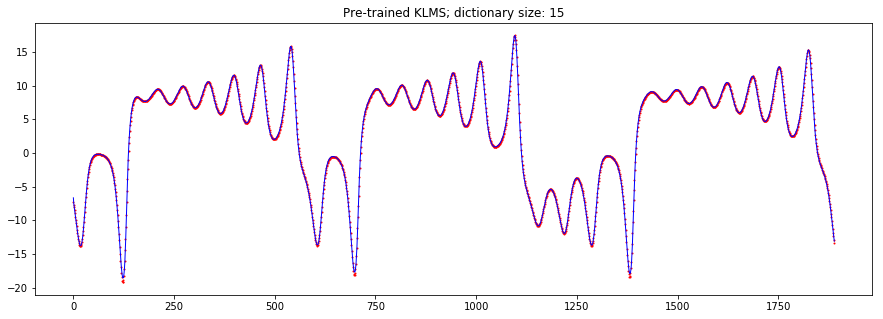

In [5]:
plot_series(y[delay:], klms.estimate[delay:], markersize=1, linewidth=1, 
            figsize=(15, 5), title=f'Pre-trained KLMS; dictionary size: {len(klms.support_vectors)}')

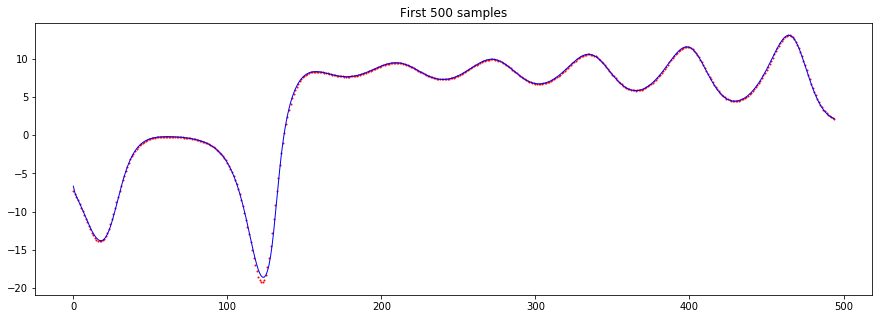

In [6]:
plot_series(y[delay:500], klms.estimate[delay:500], markersize=1, linewidth=1, 
            figsize=(15, 5), title=f'First 500 samples')

### 2.2. KLMS without Pretrained Parameters

In [7]:
klms_params = {
    'kernel': GaussianKernel(sigma=float(sigma_k_post)),
    'learning_rate': 10e-2,
    'delay': int(delay),
    'sparsifiers': [NoveltyCriterion(0.9969, 1.0)],
}

x = y_prog
y = y_prog

klms = KlmsFilter(x, y)
klms.fit(**klms_params)

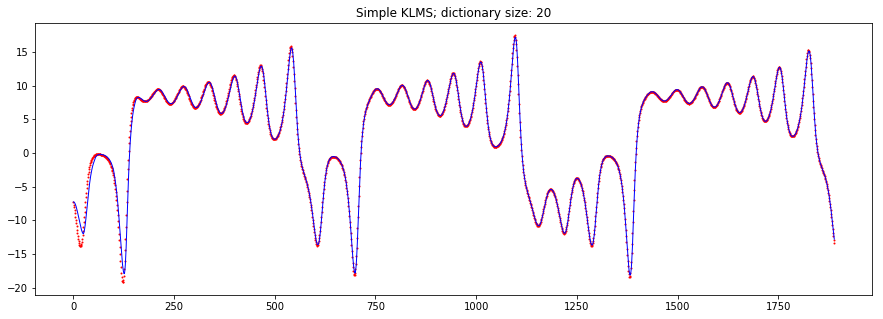

In [8]:
plot_series(y[delay:], klms.estimate[delay:], markersize=1, linewidth=1, 
            figsize=(15, 5), title=f'Simple KLMS; dictionary size: {len(klms.support_vectors)}')

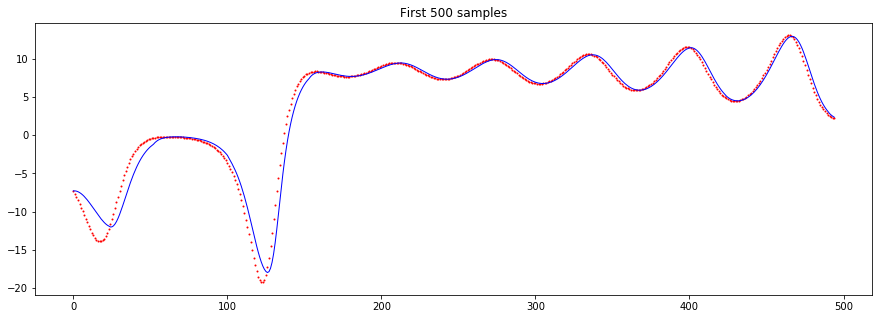

In [9]:
plot_series(y[delay:500], klms.estimate[delay:500], markersize=1, linewidth=1, 
            figsize=(15, 5), title=f'First 500 samples')